## Fake News Detection: Classification Modelling

Prepared by: Keina Aoki
Date: January 2024

In [321]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Table of Contents

[Data Dictionary](#Data_Dictionary)

[VADER Sentiment Scores](#VADER_Sentiment_Scores)

[Exploratory Data Analysis](#Simple_Exploratory_Data_Analysis)

[Train/Test/Validation Split](#Train/Test/Validation_Split)

[Text Vectorization](#Text_Vectorization)

[Modelling](#Modelling)
- [Logisitc Regression](#Logistic_Regression)
    - [Baseline Model](#Baseline_Logistic_Regression_Model)
    - [Hypertuning](#Hyperparameter_Tuning_(C))
    - [Final Model](#Final_Logistic_Regreesion_Model)
    - [Model_Evaluation](#Model_Evaluation)
- [Decision Tree Classifier](#Decision_Tree_Classifier)
    - [Baseline Model](#Baseline_Decision_Tree_Model)
    - [Hypertuning](#Hyperparameter_Tuning)
    - [Final Model](#Final_Decision_Tree_Model)
    - [Model_Evaluation](#Model_Evaluation)
- [Naive Bayes Classifier](#Naive_Bayes_Classifier)
    - [Baseline Model](#Baseline_Naive_Bayes_Model)
    - [Hypertuning](#Hyperparameter_Tuning)
    - [Final Model](#Final_Naive_Bayes_Model)
    - [Model_Evaluation](#Model_Evaluation)

### Recap

This will be the third continuation of training a model to identify fake news through twitter posts. In today's digital age, social media and online news sources offers quick access to vast amounts of data. Yet the creation and dissemination of fake news poses an emerging challenge as it has the potential to generate mistrust in persons and institutions. There are broadly two types of fake information: misinformation and disinformation. 1) Misinformation refers to information which is incorrect or misleading or taken out of context unsuspectingly shared by people. 2) Disinformation refers to false information spread deliberately with the intent to deceive public opinion. While both mis/disinformation exist because people want to share a certain narrative that aligns with their interests and beliefs, disinformation is more dangerous and damaging because its intention is to destabilize societies. It is meant to influence people's beliefs, attitudes and consequentially, their behavior by purposely only providing one side of a narrative. Nonetheless, disinformation poses a threat to democracy because it reinforces polarizing viewpoints.

The authenticity of news content has become difficult to discern not only because of social media algorithms that determine the content a user sees and interacts with, but because human minds are faulty to judgement about information. Thus, it is imperative to develop tools that can detect fake news to ensure that we are well informed.

This project aims to train a model to identify fake news through twitter posts (now known as X). It will employ machine learning techniques such as natural language processing and eventually use sentiment analysis to assess the credibility of a news story based on the emotion that the words in the statement elicits. The data set is sourced from https://www.unb.ca/cic/datasets/truthseeker-2023.html which includes fake and real news.


We started by exploring the twitter post dataset. There was minimal cleaning required as the dataset did not have null values nor duplicates. However, after removing columns that added no additional information about the twitter posts, we moved to some exploratory data analysis. We found that many of the parts of speech tag features had a heavy right skew and some of the features about the twitter posts' (number of retweets, followers, likes, etc.) had multicollinearity. Thus, we instead used VADER Sentiment Scores and CountVectorizer to predict fake news in twitter posts. In the previous model, we used Logistic Regression, Decision Tree Classifier, Naive Bayes Classifier, and K-Nearest Neighbour to produce baseline models that predicted our target variable (fake news (0) and real news (1)) from a document-term-matrix and VADER Sentiment Scores. 

In this notebook, we will build on three baseline models (Logisitic Regression, Decision Tree Classifer, and Naive Bayes Classifier) by tuning the models and evaluating them.

### Data Dictionary

In [322]:
# load the data and store to df variable
df = pd.read_csv("Features_For_Traditional_ML_Techniques.csv", index_col=0)

# preview the first 5 rows
df.head()

,majority_target,statement,BinaryNumTarget,tweet,followers_count,friends_count,favourites_count,statuses_count,listed_count,following,...,determiners,conjunctions,dots,exclamation,questions,ampersand,capitals,digits,long_word_freq,short_word_freq
0,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...,4262.0,3619.0,34945.0,16423.0,44.0,0.0,...,0,0,5,0,1,0,33,3,5,19
1,True,End of eviction moratorium means millions of A...,1.0,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,1393.0,1621.0,31436.0,37184.0,64.0,0.0,...,0,2,1,0,0,0,14,0,2,34
2,True,End of eviction moratorium means millions of A...,1.0,THE SUPREME COURT is siding with super rich pr...,9.0,84.0,219.0,1184.0,0.0,0.0,...,0,1,0,0,0,0,3,0,4,10
3,True,End of eviction moratorium means millions of A...,1.0,@POTUS Biden Blunders\n\nBroken campaign promi...,4262.0,3619.0,34945.0,16423.0,44.0,0.0,...,0,1,3,0,0,1,6,8,1,30
4,True,End of eviction moratorium means millions of A...,1.0,@OhComfy I agree. The confluence of events rig...,70.0,166.0,15282.0,2194.0,0.0,0.0,...,0,1,3,0,1,0,11,3,2,19


Our dataset (Features_For_Traditional_ML.csv) includes the following fields:


| Name | Description   |
|:------|:------|
|  unique_count |number of unique, complex words|
|total_count |total number of words|
|ORG_percent | Percent of text including spaCy ORG tags (organizations, companies, agencies, institutions)
|NORP_percent |Percent of text including spaCy NORP tags (nationalities or religious or political groups)
|GPE_percent | Percent of text including spaCy GPE tags (countries, cities, states)
|PERSON_percent | Percent of text including spaCy PERSON tags (people, including fictional)
|MONEY_percent | Percent of text including spaCy MONEY tags (monetary values, including unit)
|DATE_percent | Percent of text including spaCy DATE tags (absolute or relative dates or periods)
|CARDINAL_percent | Percent of text including spaCy CARDINAL tags (numerals that do not fall under another type)
|PERCENT_percent | Percent of text including spaCy PERCENT tags (percentage, including "%")
|ORDINAL_percent | Percent of text including spaCy ORDINAL tags ("first", "second", etc.)
|FAC_percent | Percent of text including spaCy FAC tags (buildings, airports, highways, bridges, etc.)
|LAW_percent | Percent of text including spaCy LAW tags (named documents made into laws)
|PRODUCT_percent | Percent of text including spaCy PRODUCT tags (objects, vehicles, foods, etc. (not services))
|EVENT_percent | Percent of text including spaCy EVENT tags (named hurricanes, battles, wars, sports events, etc.)
|TIME_percent | Percent of text including spaCy TIME tags (times smaller than a day)
|LOC_percent | Percent of text including spaCy LOC tags (non-GPE locations, mountain ranges, bodies of water)
|WORK_OF_ART_percent | Percent of text including spaCy WOA tags (titles of books, songs, etc.)
|QUANTITY_percent | Percent of text including spaCy QUANTITY tags (measurements, as of weight or distance) 
|LANGUAGE_percent | Percent of text including spaCy LANGUAGE tags (any named language)
|Max Word | Length of the longest word in the sentence
|Min Word | Length of the shortest word in the sentence
|Avg Word Length | Average length of words in the sentence
|present_verb | Number of present tense verbs
|past_verb | Number of past tense verbs
|adjectives | Number of adjectives
|adverbs | Number of adverbs
|adpositions | Number of adpositions
|pronouns | Number of pronouns
|TO’s | Number of to usages
|determiners | Number of determiners
|conjunctions | Number of conjunctions
|dots | Number of (.) used
|exclamations | Number of (!) used
|question | Number of (?) used
|ampersand | Number of (&) used
|capitals | Number of capitalized letters
|digits | Number of digits (0-9) used
|word_count | Number of words
|long_word_freq | Number of long words
|short_word_freq | Number of short words
|followers_count | Number of followers
|friends_count | Number of friends
|favourites_count | Number of favourites across all tweets
|statuses_count | Number of tweets
|listed_count | Number of tweets the user has in lists
|mentions | Number of times the user was mentioned
|replies | Number of replies the user has
|retweets | Number of retweets the user has
|favourites | Number of favourites the user has
|hashtags | Number of hashtags (#) the user has used
|URLs | whether the user has a provided a url in relation to their profile
|quotes | Number of times the user has been quote tweeted
|BotScoreBinary | Binary score whether the user is considered a bot or not
|cred | Credibility score
|normalized_influence | Influence score the user has, normalized
|majority_target | Truth value of the tweet
|statement | Headline of a new article
|BinaryNumTarget | Binary representation of the statement's truth value (1 = True / 0 = False)
|tweet | Twitter posts related to the associated manual keywords

Note: spaCy tags refers to the spaCy natural language processing model that classifies text into categories

In [323]:
# Create a dataframe just for the twitter posts 
tweet = df["tweet"]

In [324]:
tweet = pd.DataFrame(tweet)
tweet.head()

,tweet
0,@POTUS Biden Blunders - 6 Month Update\n\nInfl...
1,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...
2,THE SUPREME COURT is siding with super rich pr...
3,@POTUS Biden Blunders\n\nBroken campaign promi...
4,@OhComfy I agree. The confluence of events rig...


## VADER Sentiment Scores

We will use the vaderSentimentAnalyzer package to extract sentiment from text. Because VADER is specifically attuned for social media text, we will not be removing punctuation and capital letters. 

In [325]:
# remove new line indicator 
tweet.replace("\n", "", regex=True, inplace=True)
tweet.head()

,tweet
0,@POTUS Biden Blunders - 6 Month UpdateInflatio...
1,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...
2,THE SUPREME COURT is siding with super rich pr...
3,"@POTUS Biden BlundersBroken campaign promises,..."
4,@OhComfy I agree. The confluence of events rig...


In [326]:
# Instantiate SentimentIntensityAnalyzer 
obj = SentimentIntensityAnalyzer()

# The sentiment analysis takes in lists so we will turn our dataframe into a list
tweets_list = tweet["tweet"].to_list()

In [327]:
# get the polarity score from each tweet in the list, output a list of scores
scores_list = []
for tweet in tweets_list:
    score = obj.polarity_scores(tweet)
    scores_list.append(score)
# create a dataframe with the tweets
tweet_post = pd.DataFrame(tweets_list, columns= ['tweet'])
# create a dataframe with scores
scores_df = pd.DataFrame(scores_list)

In [328]:
# merge these two dataframes together
tweet_score_df= pd.concat([tweet_post,scores_df], axis=1)
tweet_score_df

,tweet,neg,neu,pos,compound
0,@POTUS Biden Blunders - 6 Month UpdateInflatio...,0.303,0.646,0.051,-0.9169
1,@S0SickRick @Stairmaster_ @6d6f636869 Not as m...,0.228,0.772,0.000,-0.8807
2,THE SUPREME COURT is siding with super rich pr...,0.292,0.457,0.252,-0.3147
3,"@POTUS Biden BlundersBroken campaign promises,...",0.231,0.612,0.157,-0.6828
4,@OhComfy I agree. The confluence of events rig...,0.235,0.708,0.057,-0.8316
...,...,...,...,...,...
134193,Joe Biden's family owned African slaves....Joe...,0.091,0.909,0.000,-0.3182
134194,"Joe Bidens great, great grandfather was a slav...",0.000,0.573,0.427,0.8481
134195,"@ChevyChaseToGo ""Joe Bidens great-grandfather ...",0.113,0.887,0.000,-0.3182
134196,@JoeBiden Facts are Bidens VP Kamala Harris Gr...,0.000,0.681,0.319,0.9601


The resulting datafame has 134198 rows and 5 columns: the tweet, negative sentiment score, neutral sentiment score, positive sentiment score and compound which is the overall sentiment score. 

### Simple Exploratory Data Analysis

Here, we create a barplot to see the difference of overall sentiment scores between fake and real news. 

In [329]:
compound = tweet_score_df["compound"]
compound_truth = pd.concat([compound.reset_index(drop=True), y.reset_index(drop=True)], axis=1)

In [330]:
compound_truth.head()

,compound,BinaryNumTarget
0,-0.9169,1.0
1,-0.8807,1.0
2,-0.3147,1.0
3,-0.6828,1.0
4,-0.8316,1.0


In [331]:
custom_index = [0,1]

In [332]:
result = pd.DataFrame(compound_truth.groupby('BinaryNumTarget')['compound'].sum())

In [333]:
result.head()

,compound
BinaryNumTarget,
0.0,-8759.3087
1.0,-5385.9291


In [334]:
df_reset = result.reset_index(drop=False)
df_reset.head()

,BinaryNumTarget,compound
0,0.0,-8759.3087
1,1.0,-5385.9291


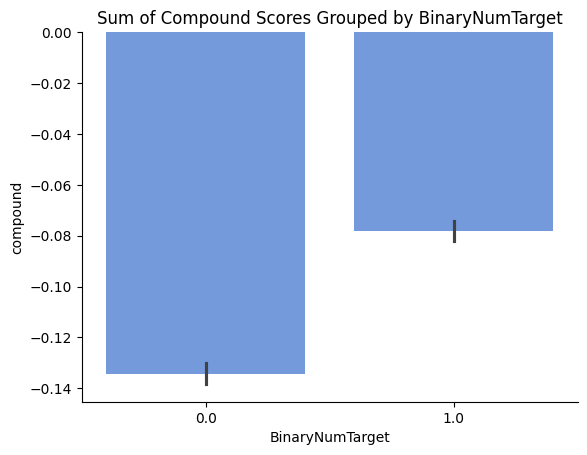

In [335]:
sns.barplot(data=compound_truth, x="BinaryNumTarget", y="compound", color="cornflowerblue")
sns.despine()
plt.title("Sum of Compound Scores Grouped by BinaryNumTarget")
plt.show()

The barplot shows that the compound sentiment score of fake news has more negative sentiment as opposed to real news. It appears that the sentiment of a twitter post may help us predict fake vs. real news. 

### Train/Test/Validation Split

Here, we split the data into train, test, and validation. We will then do a vectorization of the text so that we can create a document-term matrix. The columns will be words and the rows will indicate how many of those words are present in the tweet.

In [336]:
# X is dataframe with sentiment scores and the twitter post itself
X = tweet_score_df

# y is the target variable
y = df["BinaryNumTarget"]

In [337]:
print(f' The shape of our independent features is {X.shape}')
print(f' The shape of our target variable is {y.shape}')

 The shape of our independent features is (134198, 5)
 The shape of our target variable is (134198,)


In our train/test/validation split, we'll take
* Train + Validation Sets: 80%
* Test Set: 20%

Let's separate our our test set.


In [338]:
# Taking a chuck for our 20% test set
X_remainder, X_test, y_remainder, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)

In [339]:
X_remainder.head()

,tweet,neg,neu,pos,compound
35020,@realDonaldTrump Trump New Spokesman Summer 20...,0.496,0.504,0.000,-0.9406
20270,It then proceeds to hold a trial in July 2017 ...,0.125,0.875,0.000,-0.7650
106775,@meenaharris @JoeBiden Ivanka plagiarized Joe ...,0.000,0.887,0.113,0.6369
74304,@StanislausPach1 @CNN The point is that women ...,0.000,0.676,0.324,0.8591
47158,"A VACCINE SUPPOSE TO ""PREVENT YOU FROM GETTING...",0.319,0.619,0.062,-0.9628


Now, `X_remainder` and `y_remainder` contain the other 80%. Of remaining data, we take a 70% training set and 30% validation set.

In [340]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = train_test_split(X_remainder, y_remainder, test_size = 0.3, random_state=1)

In [341]:
print(f' The shape of our X_test is {X_test.shape}')
print(f' The shape of our y_test is {y_test.shape}')
print(f' The shape of our X_train is {X_train.shape}')
print(f' The shape of our y_train is {y_train.shape}')
print(f' The shape of our X_validation is {X_validation.shape}')
print(f' The shape of our y_validation is {y_validation.shape}')

 The shape of our X_test is (26840, 5)
 The shape of our y_test is (26840,)
 The shape of our X_train is (75150, 5)
 The shape of our y_train is (75150,)
 The shape of our X_validation is (32208, 5)
 The shape of our y_validation is (32208,)


#### Split tweet from rest of features to vectorize tweets

In [342]:
# tweets only in each set
X_remainder_tweet = X_remainder["tweet"]
X_train_tweet = X_train["tweet"]
X_test_tweet = X_test["tweet"]
X_val_tweet = X_validation["tweet"]

In [343]:
# everything but tweets in each set
X_remainder_all= X_remainder.drop(columns = ["tweet"])
X_train_all = X_train.drop(columns = ["tweet"])
X_test_all = X_test.drop(columns = ["tweet"])
X_val_all = X_validation.drop(columns = ["tweet"])

## Text Vectorization

Here, we create a document term matrix which are 500 columns of individual words and rows of the count of the word in the tweet.

In [344]:
# Create a custom tokenizer

# Instantiate porter stemming from nltk
stemmer = nltk.stem.PorterStemmer() 

# Define all english stop words
English_stop_words = stopwords.words('english')

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark, '').lower()
    
    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words=[]
    
    # remove stopwords and any tokens that are just empty strings or numeric values
    for word in listofwords:
        if (not word in English_stop_words) and (word != '') and (not word.isnumeric()):
            # stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)
    return listofstemmed_words 

In [345]:
# Instantiate CountVectorizer

bagofwords = CountVectorizer(min_df = 1,
                             max_features = 500,
                             tokenizer = my_tokenizer,
                             ngram_range=(1,3))

In [346]:
# Fit and transform training data
bagofwords.fit(X_train_tweet)
X_train_bow = bagofwords.transform(X_train_tweet)
X_train_bow

<75150x500 sparse matrix of type '<class 'numpy.int64'>'
	with 706269 stored elements in Compressed Sparse Row format>

In [347]:
# Transform validation data
X_val_bow = bagofwords.transform(X_val_tweet)
X_val_bow

<32208x500 sparse matrix of type '<class 'numpy.int64'>'
	with 302388 stored elements in Compressed Sparse Row format>

In [348]:
# Train data
X_train_tweetdf = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=X_train_bow.toarray())
X_train_tweetdf

,abort,access,accord,act,actual,ad,administr,admit,african,african american,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
75146,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
75147,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75148,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [349]:
# Validation data
X_val_tweetdf = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=X_val_bow.toarray())
X_val_tweetdf 

,abort,access,accord,act,actual,ad,administr,admit,african,african american,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32203,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32205,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0


In [350]:
# Transform test data
X_test_bow = bagofwords.transform(X_test_tweet)
X_test_bow

<26840x500 sparse matrix of type '<class 'numpy.int64'>'
	with 251409 stored elements in Compressed Sparse Row format>

In [351]:
# Test data
X_test_tweetdf = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=X_test_bow.toarray())
X_test_tweetdf 

,abort,access,accord,act,actual,ad,administr,admit,african,african american,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26835,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26836,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [352]:
# Concat all features with sentiment scores

# Train Data
X_train = pd.concat([X_train_all.reset_index(drop=True), X_train_tweetdf.reset_index(drop=True)], axis=1)

# Validation Data
X_validation = pd.concat([X_val_all.reset_index(drop=True), X_val_tweetdf.reset_index(drop=True)], axis=1)

# Test Data
X_test = pd.concat([X_test_all.reset_index(drop=True), X_test_tweetdf.reset_index(drop=True)], axis=1)

In [353]:
X_train.head()

,neg,neu,pos,compound,abort,access,accord,act,actual,ad,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0.042,0.847,0.111,0.5994,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.162,0.838,0.000,-0.6124,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.189,0.727,0.084,-0.4404,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.134,0.866,0.000,-0.7517,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000,0.862,0.138,0.6814,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [354]:
X_validation.head()

,neg,neu,pos,compound,abort,access,accord,act,actual,ad,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0.111,0.827,0.061,-0.2732,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000,0.843,0.157,0.4449,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.305,0.695,0.000,-0.7845,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
X_test.head()

,neg,neu,pos,compound,abort,access,accord,act,actual,ad,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0.230,0.661,0.109,-0.6369,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000,1.000,0.000,0.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.055,0.945,0.000,-0.1027,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.138,0.862,0.000,-0.8176,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.241,0.759,0.000,-0.6908,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Remainder Set

In [356]:
# Transform remainder data
X_remainder_bow = bagofwords.transform(X_remainder_tweet)
X_remainder_bow

<107358x500 sparse matrix of type '<class 'numpy.int64'>'
	with 1008657 stored elements in Compressed Sparse Row format>

In [357]:
# Remainder data
X_remainder_tweetdf = pd.DataFrame(columns=bagofwords.get_feature_names_out(), data=X_remainder_bow.toarray())
X_remainder_tweetdf 

,abort,access,accord,act,actual,ad,administr,admit,african,african american,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107353,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
107356,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [358]:
# Remainder Data
X_remainder = pd.concat([X_remainder_all.reset_index(drop=True), X_remainder_tweetdf.reset_index(drop=True)], axis=1)

In [359]:
X_remainder.head()

,neg,neu,pos,compound,abort,access,accord,act,actual,ad,...,work,worker,world,would,wrong,ye,year,yet,york,your
0,0.496,0.504,0.000,-0.9406,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.125,0.875,0.000,-0.7650,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000,0.887,0.113,0.6369,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000,0.676,0.324,0.8591,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.319,0.619,0.062,-0.9628,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


## Modelling

We will be using three different classification models: Logisitic Regression, Decision Tree Classifier, and Naive Bayes Classifier. We will first fit the model, then get the training/validation accuracy and training/validition recall score. We will then tune the hyperparameters to improve the model. From tuning, we can adjust the model to get our final model and then evaluate it using a confusion matrix.

## Logisistic Regression
### Baseline Logistic Regression Model

In [119]:
# instantiate, fit and score the model
my_logreg = LogisticRegression(max_iter=1000)

my_logreg.fit(X_train, y_train)

log_train_pred = my_logreg.predict(X_train)
log_val_pred = my_logreg.predict(X_validation)

log_train_acc = my_logreg.score(X_train,y_train)
log_val_acc = my_logreg.score(X_validation, y_validation)

log_train_recall = recall_score(y_train, log_train_pred, average='weighted')
log_val_recall = recall_score(y_validation, log_val_pred, average='weighted')

In [125]:
print(f' The baseline Logistic Regression model has a train accuracy score of {log_train_acc}')
print(f' The baseline Logistic Regression model has a validation accuracy score of {log_val_acc}')
print(f' The baseline Logistic Regression model has a train recall score of {log_train_recall}')
print(f' The baseline Logistic Regression model has a validation recall score of {log_val_acc}')

 The baseline Logistic Regression model has a train accuracy score of 0.8819294743845643
 The baseline Logistic Regression model has a validation accuracy score of 0.8814890710382514
 The baseline Logistic Regression model has a train recall score of 0.8819294743845643
 The baseline Logistic Regression model has a validation recall score of 0.8814890710382514


### Hyperparameter Tuning (C)

The hyperparameter we will tune is the C value which controls the strength of regularization. We test a variety of C values.

In [121]:
train_scores = []
validation_scores = []
train_recall = []
validation_recall = []

C_range = np.array([.0000001,.000001,.00001,.0001,.001,0.1,1,10,100,1000,10000,100000,1000000])

for c in C_range:
    my_logreg = LogisticRegression(C = c, max_iter = 1000)
    my_logreg.fit(X_train,y_train)
    log_train_pred = my_logreg.predict(X_train)
    log_val_pred = my_logreg.predict(X_validation)
    
    train_acc_score = my_logreg.score(X_train, y_train)
    val_acc_score = my_logreg.score(X_validation, y_validation)
    
    train_recall_score = recall_score(y_train, log_train_pred, average='weighted')
    val_recall_score = recall_score(y_validation, log_val_pred, average='weighted')
    
    train_scores.append(train_acc_score)
    validation_scores.append(val_acc_score)
    
    train_recall.append(train_recall)
    validation_recall.append(validation_recall)


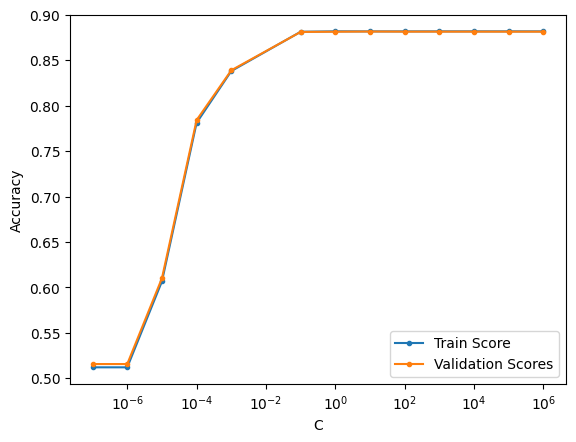

In [122]:
plt.figure()
plt.plot(C_range, train_scores,label="Train Score",marker='.')
plt.plot(C_range, validation_scores,label="Validation Scores",marker='.')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

It appears that there is very little difference in the performance of training data and the validation data. Regardless, we get the highest accuracy score when train and validation is at a value of C=1, which also happens to be the default of the logisitic regression model in sklearn.

### Final Logistic Regression Model

In [131]:
# instantiate, fit and score the model
my_logreg = LogisticRegression(C=1, max_iter=1000)

my_logreg.fit(X_train, y_train)

log_train_pred = my_logreg.predict(X_train)
log_val_pred = my_logreg.predict(X_validation)

log_train_acc = my_logreg.score(X_train,y_train)
log_val_acc = my_logreg.score(X_validation, y_validation)

log_train_recall = recall_score(y_train, log_train_pred, average='weighted')
log_val_recall = recall_score(y_validation, log_val_pred, average='weighted')

In [132]:
print(f' The final Logistic Regression model has a train accuracy score of {log_train_acc}')
print(f' The final Logistic Regression model has a validation accuracy score of {log_val_acc}')
print(f' The final Logistic Regression model has a train recall score of {log_train_recall}')
print(f' The final Logistic Regression model has a validation recall score of {log_val_acc}')

 The final Logistic Regression model has a train accuracy score of 0.8819294743845643
 The final Logistic Regression model has a validation accuracy score of 0.8814890710382514
 The final Logistic Regression model has a train recall score of 0.8819294743845643
 The final Logistic Regression model has a validation recall score of 0.8814890710382514


### Model Evaluation

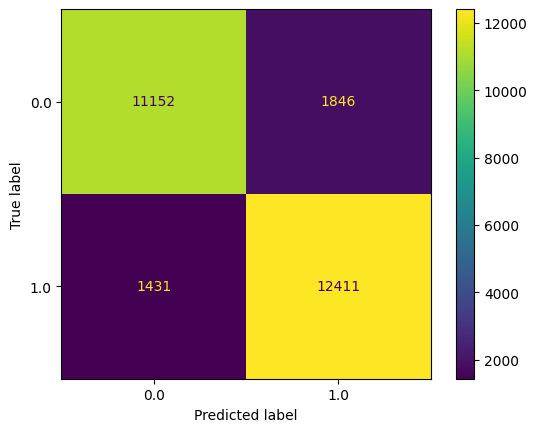

In [135]:
# soft predictions
y_pred = my_logreg.predict(X_test)

# hard predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 

In [137]:
from sklearn.metrics import classification_report

report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87     12998
         1.0       0.87      0.90      0.88     13842

    accuracy                           0.88     26840
   macro avg       0.88      0.88      0.88     26840
weighted avg       0.88      0.88      0.88     26840



The findings of the confusion matrix indicate that real news is being predicted correctly the most and fake news is also predicted correctly.

## Decision Tree Classifier
### Baseline Decision Tree Model

In [171]:
# instantiate decision tree classifier
my_dt = DecisionTreeClassifier() #choose a random max_depth

#fit to train data
my_dt.fit(X_train, y_train)

dt_train_pred = my_dt.predict(X_train)
dt_val_pred = my_dt.predict(X_validation)

dt_train_acc = my_dt.score(X_train,y_train)
dt_val_acc = my_dt.score(X_validation, y_validation)

dt_train_recall = recall_score(y_train, dt_train_pred, average='macro')
dt_val_recall = recall_score(y_validation, dt_val_pred, average='macro')

In [172]:
print(f' The baseline Decision Tree model has a train accuracy score of {dt_train_acc}')
print(f' The baseline Decision Tree model has a validation accuracy score of {dt_val_acc}')
print(f' The baseline Decision Tree model has a train recall score of {dt_train_recall}')
print(f' The baseline Decision Tree model has a validation recall score of {dt_val_acc}')

 The baseline Decision Tree model has a train accuracy score of 0.9988157019294743
 The baseline Decision Tree model has a validation accuracy score of 0.8971684053651267
 The baseline Decision Tree model has a train recall score of 0.9987935289288576
 The baseline Decision Tree model has a validation recall score of 0.8971684053651267


The result of the Baseline Decision Tree Classifier Model shows that the model is overfitting because the training accuracy score is much higher than the validation accuracy score.

### Hyperparameter Tuning

For the Decision Tree Classifier, we will tune it by adjusting the maximum depth of the decision tree and the minimum sample leaf value.

##### max_depth

In [155]:
train_scores = []
validation_scores = []
train_recall = []
validation_recall = []

depth_values = range(2,115,5)

for d in depth_values:
    my_dt = DecisionTreeClassifier(max_depth = d)
    my_dt.fit(X_train,y_train)
    dt_train_pred = my_dt.predict(X_train)
    dt_val_pred = my_dt.predict(X_validation)
    
    train_acc_score = my_dt.score(X_train, y_train)
    val_acc_score = my_dt.score(X_validation, y_validation)
    
    train_recall_score = recall_score(y_train, log_train_pred, average='macro')
    val_recall_score = recall_score(y_validation, log_val_pred, average='macro')
    
    train_scores.append(train_acc_score)
    validation_scores.append(val_acc_score)
    
    train_recall.append(train_recall)
    validation_recall.append(validation_recall)
    print(f'trained depth = {d}')

trained depth = 2
trained depth = 7
trained depth = 12
trained depth = 17
trained depth = 22
trained depth = 27
trained depth = 32
trained depth = 37
trained depth = 42
trained depth = 47
trained depth = 52
trained depth = 57
trained depth = 62
trained depth = 67
trained depth = 72
trained depth = 77
trained depth = 82
trained depth = 87
trained depth = 92
trained depth = 97
trained depth = 102
trained depth = 107
trained depth = 112


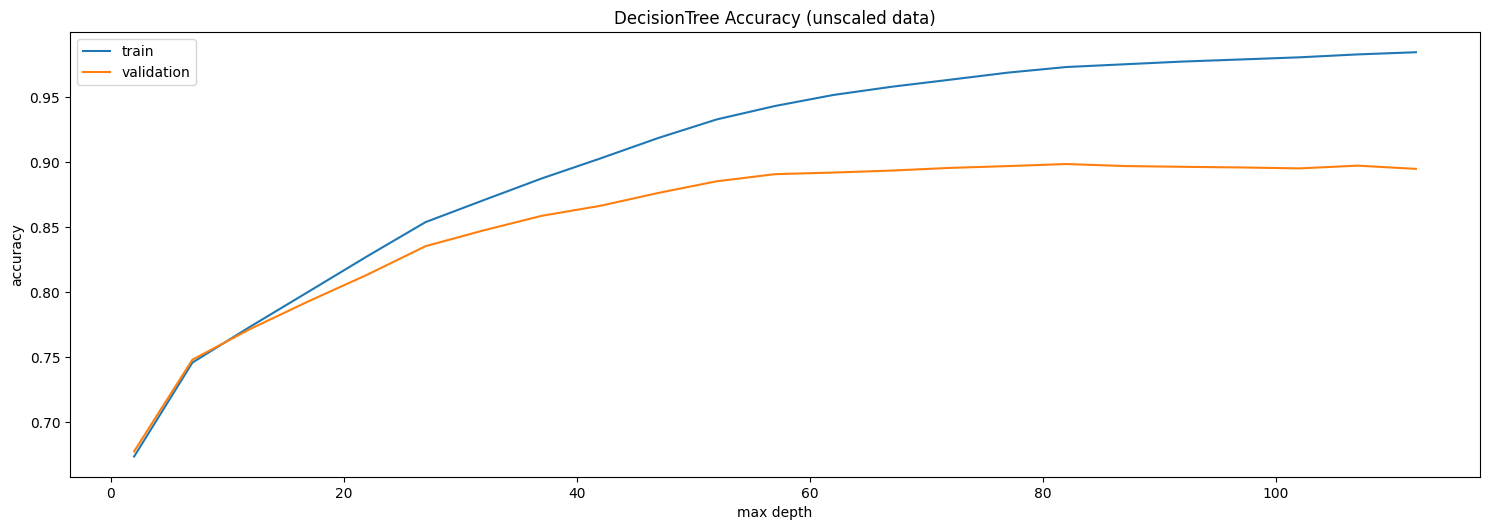

In [156]:
plt.figure(figsize=(15, 10))
    
# Plot the results
plt.subplot(211) # plot unscaled classifier results
plt.plot(depth_values, train_scores, label='train')
plt.plot(depth_values, validation_scores, label='validation')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (unscaled data)')

plt.tight_layout()
plt.show()

The graph above shows us that the maximum depth of the decision tree at about 55 has the highest accuracy in both the training and validation data. 

##### min_samples_leaf

In [241]:
train_scores_min_leaf = []
validation_scores_min_leaf = []
train_recall_min_leaf = []
validation_recall_min_leaf = []

min_leaf_values = range(1,20,1)

for n in min_leaf_values:
    my_dt = DecisionTreeClassifier(min_samples_leaf = n)
    my_dt.fit(X_train,y_train)
    dt_train_pred = my_dt.predict(X_train)
    dt_val_pred = my_dt.predict(X_validation)
    
    train_acc_score = my_dt.score(X_train, y_train)
    val_acc_score = my_dt.score(X_validation, y_validation)
    
    train_recall_score = recall_score(y_train, log_train_pred, average='macro')
    val_recall_score = recall_score(y_validation, log_val_pred, average='macro')
    
    train_scores_min_leaf.append(train_acc_score)
    validation_scores_min_leaf.append(val_acc_score)
    
    train_recall_min_leaf.append(train_recall_score)
    validation_recall_min_leaf.append(val_recall_score)
    print(f'trained minimum samples leaf = {n}')

trained minimum samples leaf = 1
trained minimum samples leaf = 2
trained minimum samples leaf = 3
trained minimum samples leaf = 4
trained minimum samples leaf = 5
trained minimum samples leaf = 6
trained minimum samples leaf = 7
trained minimum samples leaf = 8
trained minimum samples leaf = 9
trained minimum samples leaf = 10
trained minimum samples leaf = 11
trained minimum samples leaf = 12
trained minimum samples leaf = 13
trained minimum samples leaf = 14
trained minimum samples leaf = 15
trained minimum samples leaf = 16
trained minimum samples leaf = 17
trained minimum samples leaf = 18
trained minimum samples leaf = 19


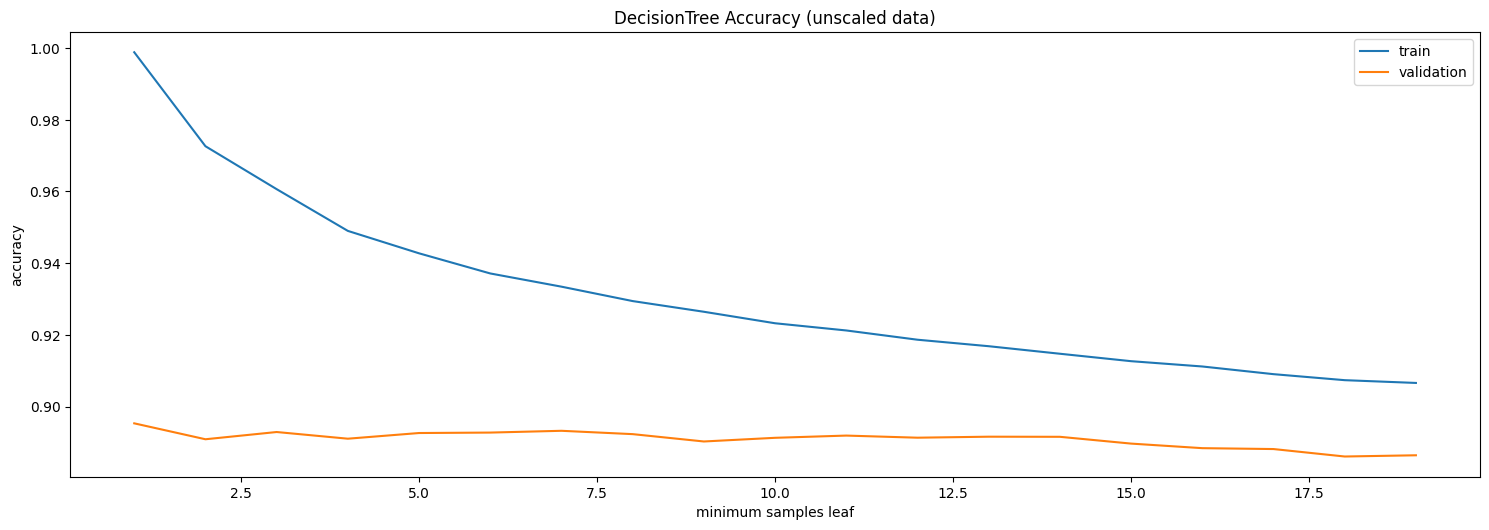

In [242]:
plt.figure(figsize=(15, 10))
    
# Plot the results
plt.subplot(211) # plot unscaled classifier results
plt.plot(min_leaf_values, train_scores_min_leaf, label='train')
plt.plot(min_leaf_values, validation_scores_min_leaf, label='validation')
plt.legend()
plt.xlabel('minimum samples leaf')
plt.ylabel('accuracy')
plt.title('DecisionTree Accuracy (unscaled data)')

plt.tight_layout()
plt.show()

As for the minimum samples leaf value, the highest accuracy would be around 3.

### Final Decision Tree Model

In [243]:
# instantiate decision tree classifier
my_dt = DecisionTreeClassifier(max_depth = 55, min_samples_leaf = 3) #choose a random max_depth

#fit to train data
my_dt.fit(X_train, y_train)

dt_train_pred = my_dt.predict(X_train)
dt_val_pred = my_dt.predict(X_validation)

dt_train_acc = my_dt.score(X_train, y_train)
dt_val_acc = my_dt.score(X_validation, y_validation)

dt_train_recall = recall_score(y_train, dt_train_pred, average='macro')
dt_val_recall = recall_score(y_validation, dt_val_pred, average='macro')

In [244]:
print(f' The final Decision Tree Classifer model has a train accuracy score of {dt_train_acc}')
print(f' The final Decision Tree Classifer model has a validation accuracy score of {dt_val_acc}')
print(f' The final Decision Tree Classifer model has a train recall score of {dt_train_recall}')
print(f' The final Decision Tree Classifer model has a validation recall score of {dt_val_acc}')

 The final Decision Tree Classifer model has a train accuracy score of 0.9223552894211576
 The final Decision Tree Classifer model has a validation accuracy score of 0.8857116244411326
 The final Decision Tree Classifer model has a train recall score of 0.921177257605196
 The final Decision Tree Classifer model has a validation recall score of 0.8857116244411326


The final Decision Tree Classifer model is no longer overfitting. Before the training accuracy score was 99.9%, where as now it has decreased to 92.2%.

### Model Evaluation

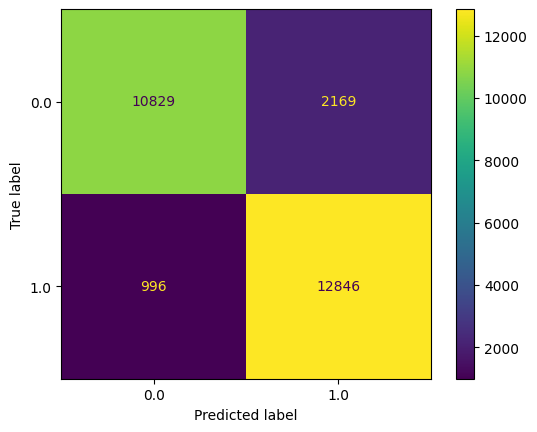

In [245]:
# soft predictions
y_pred = my_dt.predict(X_test)

# hard predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 

In [246]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.92      0.83      0.87     12998
         1.0       0.86      0.93      0.89     13842

    accuracy                           0.88     26840
   macro avg       0.89      0.88      0.88     26840
weighted avg       0.88      0.88      0.88     26840



Similar to the logisitic regression, real news is being predicted correctly the most, and fake news is also being predicted correctly, well.

## Naive Bayes Classifier

#### Baseline Naive Bayes Model

In [361]:
# we need to scale the data to run Bayes

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

In [362]:
# Instatiate our model
nbmodel = BernoulliNB()
# Fit our model
nbmodel.fit(X_train_scaled,y_train)

nb_train_pred = nbmodel.predict(X_train)
nb_val_pred = nbmodel.predict(X_validation)

nb_train_acc = nbmodel.score(X_train,y_train)
nb_val_acc = nbmodel.score(X_validation, y_validation)

nb_train_recall = recall_score(y_train, nb_train_pred, average='macro')
nb_val_recall = recall_score(y_validation, nb_val_pred, average='macro')

In [363]:
print(f' The baseline Naive Bayes model has a train accuracy score of {nb_train_acc}')
print(f' The baseline Naive Bayes model has a validation accuracy score of {nb_val_acc}')
print(f' The baseline Naive Bayes model has a train recall score of {nb_train_recall}')
print(f' The baseline Naive Bayes model has a validation recall score of {nb_val_acc}')

 The baseline Naive Bayes model has a train accuracy score of 0.8431536926147705
 The baseline Naive Bayes model has a validation accuracy score of 0.8446659215101838
 The baseline Naive Bayes model has a train recall score of 0.8425678439552178
 The baseline Naive Bayes model has a validation recall score of 0.8446659215101838


#### Hyperparameter tuning

In [364]:
train_scores_alpha = []
validation_scores_alpha = []
train_recall_alpha = []
validation_recall_alpha = []

alpha_values = np.array([0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5])

for a in alpha_values:
    nbmodel = BernoulliNB(alpha=a)
    nbmodel.fit(X_train,y_train)
    nb_train_pred = nbmodel.predict(X_train)
    nb_val_pred = nbmodel.predict(X_validation)
    
    train_acc_score = nbmodel.score(X_train, y_train)
    val_acc_score = nbmodel.score(X_validation, y_validation)
    
    train_recall_score = recall_score(y_train, nb_train_pred, average='macro')
    val_recall_score = recall_score(y_validation, nb_val_pred, average='macro')
    
    train_scores_alpha.append(train_acc_score)
    validation_scores_alpha.append(val_acc_score)
    
    train_recall_alpha.append(train_recall_score)
    validation_recall_alpha.append(val_recall_score)
    print(f'trained alpha value = {a}')

trained alpha value = 0.1
trained alpha value = 0.5
trained alpha value = 1.0
trained alpha value = 1.5
trained alpha value = 2.0
trained alpha value = 2.5
trained alpha value = 3.0
trained alpha value = 3.5
trained alpha value = 4.0
trained alpha value = 4.5
trained alpha value = 5.0
trained alpha value = 5.5


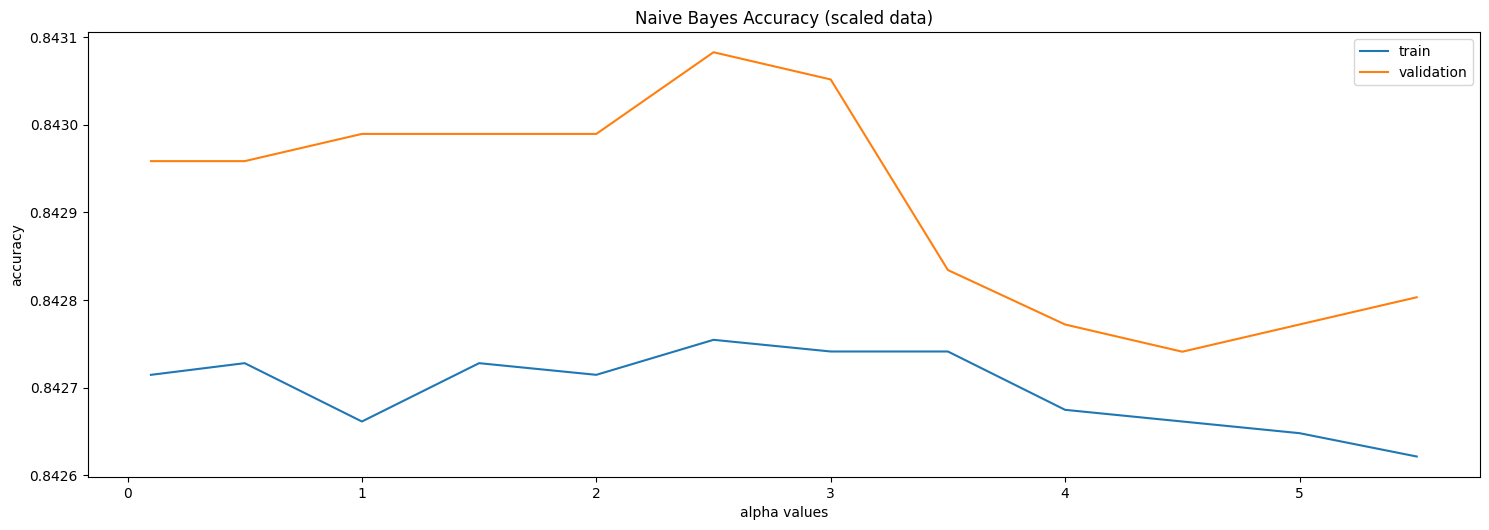

In [365]:
plt.figure(figsize=(15, 10))
    
# Plot the results
plt.subplot(211) # plot unscaled classifier results
plt.plot(alpha_values, train_scores_alpha, label='train')
plt.plot(alpha_values, validation_scores_alpha, label='validation')
plt.legend()
plt.xlabel('alpha values')
plt.ylabel('accuracy')
plt.title('Naive Bayes Accuracy (scaled data)')

plt.tight_layout()
plt.show()

The results of tuning the model shows that the highest accuracy score in both the training and validation data is when alpha has a value of 0.

#### Final Naive Bayes Model

In [366]:
# Instatiate our model
nbmodel = BernoulliNB(alpha=2.5)
# Fit our model
nbmodel.fit(X_train_scaled,y_train)

nb_train_pred = nbmodel.predict(X_train)
nb_val_pred = nbmodel.predict(X_validation)

nb_train_acc = nbmodel.score(X_train,y_train)
nb_val_acc = nbmodel.score(X_validation, y_validation)

nb_train_recall = recall_score(y_train, nb_train_pred, average='macro')
nb_val_recall = recall_score(y_validation, nb_val_pred, average='macro')

In [367]:
print(f' The final Naive Bayes model has a train accuracy score of {nb_train_acc}')
print(f' The final Naive Bayes model has a validation accuracy score of {nb_val_acc}')
print(f' The final Naive Bayes model has a train recall score of {nb_train_recall}')
print(f' The final Naive Bayes model has a validation recall score of {nb_val_acc}')

 The final Naive Bayes model has a train accuracy score of 0.8430738522954092
 The final Naive Bayes model has a validation accuracy score of 0.8445727769498261
 The final Naive Bayes model has a train recall score of 0.84248603321074
 The final Naive Bayes model has a validation recall score of 0.8445727769498261


#### Model Evaluation

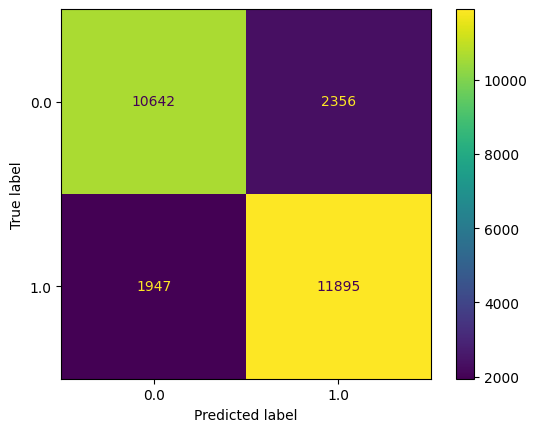

In [368]:
# soft predictions
y_pred = nbmodel.predict(X_test)

# hard predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred) 

In [369]:
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83     12998
         1.0       0.83      0.86      0.85     13842

    accuracy                           0.84     26840
   macro avg       0.84      0.84      0.84     26840
weighted avg       0.84      0.84      0.84     26840



Optimizing the alpha level in the Naive Bayes Classification model did not improve the model at all.

**Conclusion** 

Based on the modelling, hyperparameter optimizaiton and model evaluation performed in this notebook, the best performing model was the deicison tree classifier. We could use the twitter posts' text and VADER sentiment scores to train our model to predict the classification of tweets into real and fake. 